In [1]:
# ============================================================
# 0. 기본 설정
# ============================================================
import os
import json
import random
from collections import Counter, defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image

# Notebook에서 그래프 바로 표시
%matplotlib inline

# 그래프 스타일
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)

# 경로 설정 (홈 디렉토리: /data/ephemeral/home)
ROOT_DIR = os.path.expanduser("~")

DATA_DIR = os.path.join(ROOT_DIR, "dataset")   # /home/dataset
TRAIN_JSON = os.path.join(DATA_DIR, "train.json")
TEST_JSON  = os.path.join(DATA_DIR, "test.json")

TRAIN_IMG_DIR = os.path.join(DATA_DIR, "train")  # /home/dataset/train
TEST_IMG_DIR  = os.path.join(DATA_DIR, "test")   # /home/dataset/test

print("ROOT_DIR     :", ROOT_DIR)
print("DATA_DIR     :", DATA_DIR)
print("TRAIN_JSON   :", TRAIN_JSON, "=>", os.path.exists(TRAIN_JSON))
print("TEST_JSON    :", TEST_JSON,  "=>", os.path.exists(TEST_JSON))
print("TRAIN_IMG_DIR:", TRAIN_IMG_DIR, "=>", os.path.exists(TRAIN_IMG_DIR))
print("TEST_IMG_DIR :", TEST_IMG_DIR,  "=>", os.path.exists(TEST_IMG_DIR))


ROOT_DIR     : /data/ephemeral/home
DATA_DIR     : /data/ephemeral/home/dataset
TRAIN_JSON   : /data/ephemeral/home/dataset/train.json => True
TEST_JSON    : /data/ephemeral/home/dataset/test.json => True
TRAIN_IMG_DIR: /data/ephemeral/home/dataset/train => True
TEST_IMG_DIR : /data/ephemeral/home/dataset/test => True


In [ ]:
# ============================================================
# 1. COCO Annotation 로드 함수
# ============================================================

def load_coco_json(json_path):
    """
    COCO format json을 로드하고
    images / annotations / categories를 DataFrame으로 반환.
    """
    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)

    images_df = pd.DataFrame(data["images"])
    ann_df    = pd.DataFrame(data["annotations"])
    cats_df   = pd.DataFrame(data["categories"])

    print(f"[{os.path.basename(json_path)}] "
          f"images: {len(images_df)}, annotations: {len(ann_df)}, categories: {len(cats_df)}")

    return images_df, ann_df, cats_df, data


train_images, train_anns, train_cats, train_raw = load_coco_json(TRAIN_JSON)


[train.json] images: 4883, annotations: 23144, categories: 10


In [ ]:
# ============================================================
# 2. Category 정보 확인
# ===========================================================

print("\n=== Train Categories ===")
display(train_cats)

# id -> name 매핑
cat_id_to_name = dict(zip(train_cats["id"], train_cats["name"]))
print("\nCategory mapping (id -> name):")
for cid, cname in cat_id_to_name.items():
    print(f"{cid}: {cname}")



=== Train Categories ===


,id,name,supercategory
0,0,General trash,General trash
1,1,Paper,Paper
2,2,Paper pack,Paper pack
3,3,Metal,Metal
4,4,Glass,Glass
5,5,Plastic,Plastic
6,6,Styrofoam,Styrofoam
7,7,Plastic bag,Plastic bag
8,8,Battery,Battery
9,9,Clothing,Clothing



Category mapping (id -> name):
0: General trash
1: Paper
2: Paper pack
3: Metal
4: Glass
5: Plastic
6: Styrofoam
7: Plastic bag
8: Battery
9: Clothing


In [4]:
# ============================================================
# 3. Annotation + Image merge (train)
#    - bbox, category, image size 등 한 테이블에 합치기
# ============================================================

# COCO bbox: [x_min, y_min, width, height]
train_anns["bbox_x"] = train_anns["bbox"].apply(lambda x: x[0])
train_anns["bbox_y"] = train_anns["bbox"].apply(lambda x: x[1])
train_anns["bbox_w"] = train_anns["bbox"].apply(lambda x: x[2])
train_anns["bbox_h"] = train_anns["bbox"].apply(lambda x: x[3])
train_anns["bbox_area"] = train_anns["bbox_w"] * train_anns["bbox_h"]

# category name 추가
train_anns["category_name"] = train_anns["category_id"].map(cat_id_to_name)

# image 정보와 merge (image_id 기준)
train_df = train_anns.merge(
    train_images[["id", "file_name", "width", "height"]],
    left_on="image_id",
    right_on="id",
    how="left",
    suffixes=("", "_img"),
)

train_df = train_df.drop(columns=["id_img"])
print("\n=== train_df head ===")
display(train_df.head())



=== train_df head ===


,image_id,category_id,area,bbox,iscrowd,id,bbox_x,bbox_y,bbox_w,bbox_h,bbox_area,category_name,file_name,width,height
0,0,0,257301.66,"[197.6, 193.7, 547.8, 469.7]",0,0,197.6,193.7,547.8,469.7,257301.66,General trash,train/0000.jpg,1024,1024
1,1,3,10402.56,"[0.0, 407.4, 57.6, 180.6]",0,1,0.0,407.4,57.6,180.6,10402.56,Metal,train/0001.jpg,1024,1024
2,1,7,26259.36,"[0.0, 455.6, 144.6, 181.6]",0,2,0.0,455.6,144.6,181.6,26259.36,Plastic bag,train/0001.jpg,1024,1024
3,1,4,69096.17,"[722.3, 313.4, 274.3, 251.9]",0,3,722.3,313.4,274.3,251.9,69096.17,Glass,train/0001.jpg,1024,1024
4,1,5,24164.58,"[353.2, 671.0, 233.7, 103.4]",0,4,353.2,671.0,233.7,103.4,24164.58,Plastic,train/0001.jpg,1024,1024


In [5]:
# ============================================================
# 4. 전체 통계 요약 (train)
# ============================================================

n_images = train_images["id"].nunique()
n_anns   = len(train_anns)
n_cats   = len(train_cats)

print("\n=== Train 데이터 개요 ===")
print(f"- 이미지 수: {n_images}")
print(f"- Annotation 수: {n_anns}")
print(f"- Category 수: {n_cats}")

anns_per_image = train_anns.groupby("image_id")["id"].count()
print(f"- 이미지당 평균 bbox 개수: {anns_per_image.mean():.2f}")
print("\n이미지당 bbox 개수 분포:")
display(anns_per_image.describe())



=== Train 데이터 개요 ===
- 이미지 수: 4883
- Annotation 수: 23144
- Category 수: 10
- 이미지당 평균 bbox 개수: 4.74

이미지당 bbox 개수 분포:


count    4883.000000
mean        4.739709
std         6.355155
min         1.000000
25%         1.000000
50%         2.000000
75%         6.000000
max        71.000000
Name: id, dtype: float64


=== Class distribution (bbox 기준) ===


category_name
Paper            6352
Plastic bag      5178
General trash    3966
Plastic          2943
Styrofoam        1263
Glass             982
Metal             936
Paper pack        897
Clothing          468
Battery           159
Name: count, dtype: int64

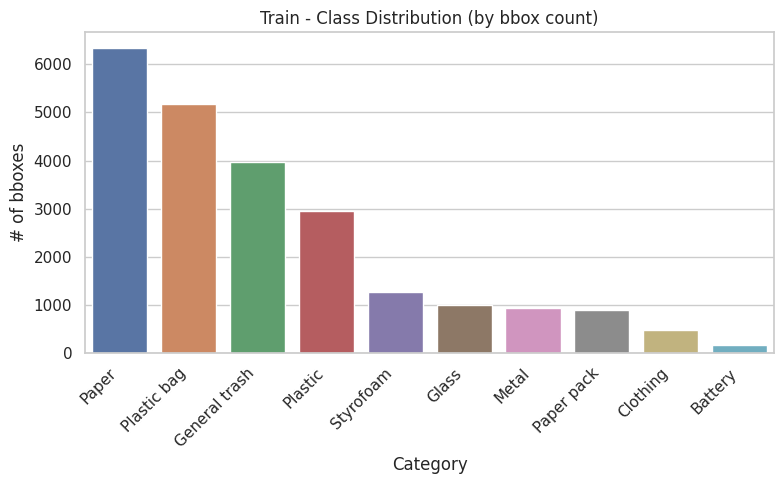

In [13]:
# ============================================================
# 5. 클래스 분포 (bbox 기준)
# ============================================================
cat_counts = train_df["category_name"].value_counts().sort_values(ascending=False)
print("\n=== Class distribution (bbox 기준) ===")
display(cat_counts)

plt.figure()
sns.barplot(x=cat_counts.index, y=cat_counts.values)
plt.xticks(rotation=45, ha="right")
plt.title("Train - Class Distribution (by bbox count)")
plt.xlabel("Category")
plt.ylabel("# of bboxes")
plt.tight_layout()
plt.show()



=== 이미지 크기 예시 ===


,file_name,width,height
0,train/0000.jpg,1024,1024
1,train/0001.jpg,1024,1024
2,train/0002.jpg,1024,1024
3,train/0003.jpg,1024,1024
4,train/0004.jpg,1024,1024


/data/ephemeral/home/py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


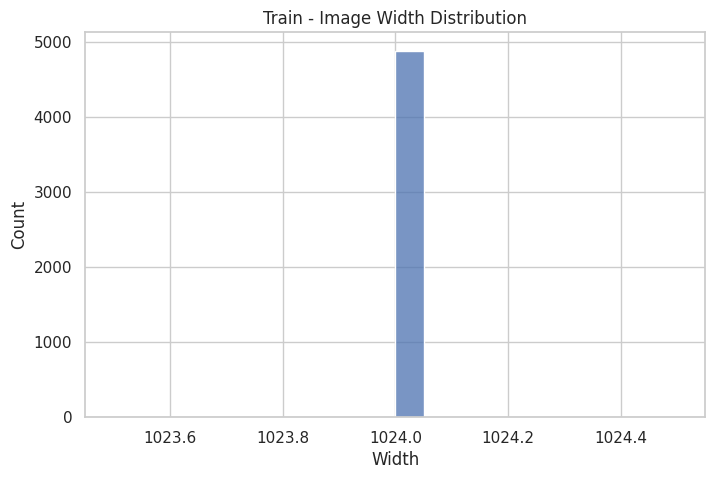

/data/ephemeral/home/py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


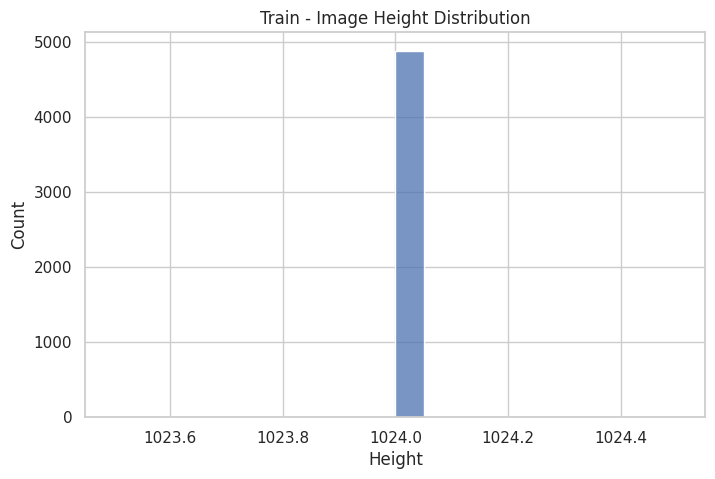

/data/ephemeral/home/py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


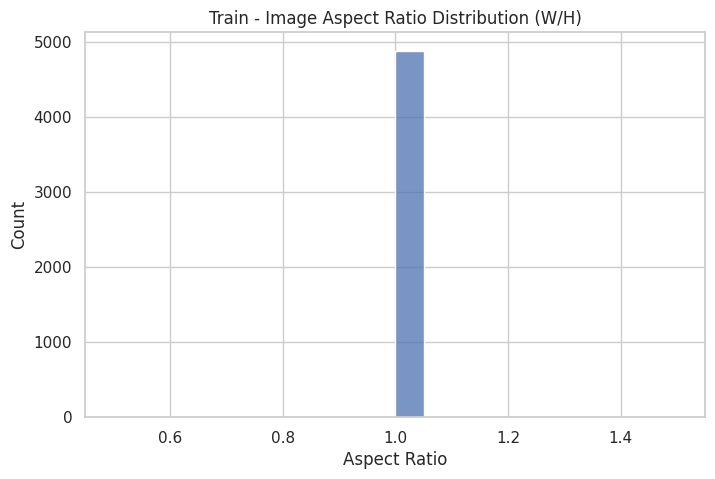

In [7]:
# ============================================================
# 6. 이미지 크기 분포 (train)
# ============================================================

print("\n=== 이미지 크기 예시 ===")
display(train_images[["file_name", "width", "height"]].head())

plt.figure()
sns.histplot(train_images["width"], bins=20)
plt.title("Train - Image Width Distribution")
plt.xlabel("Width")
plt.ylabel("Count")
plt.show()

plt.figure()
sns.histplot(train_images["height"], bins=20)
plt.title("Train - Image Height Distribution")
plt.xlabel("Height")
plt.ylabel("Count")
plt.show()

train_images["aspect_ratio"] = train_images["width"] / train_images["height"]
plt.figure()
sns.histplot(train_images["aspect_ratio"], bins=20)
plt.title("Train - Image Aspect Ratio Distribution (W/H)")
plt.xlabel("Aspect Ratio")
plt.ylabel("Count")
plt.show()


/data/ephemeral/home/py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


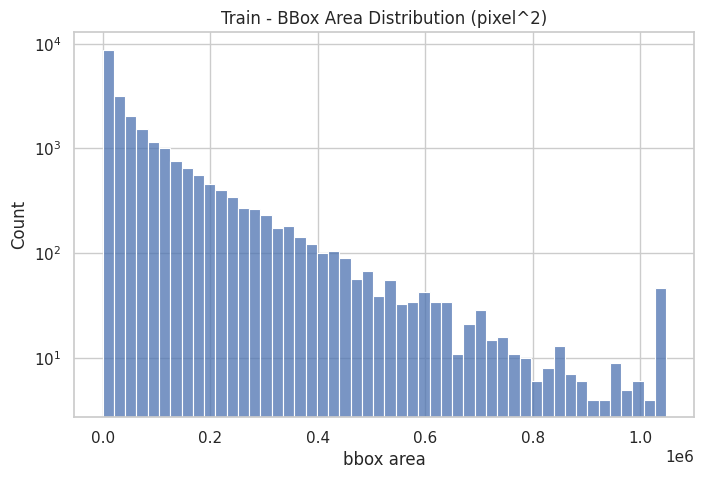

/data/ephemeral/home/py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


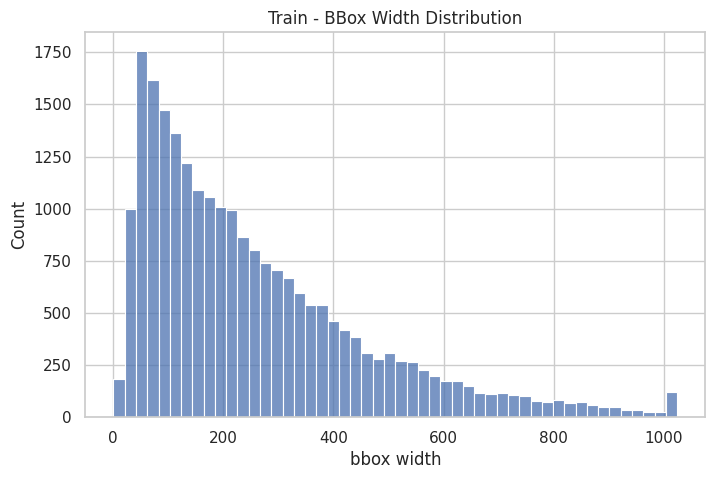

/data/ephemeral/home/py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


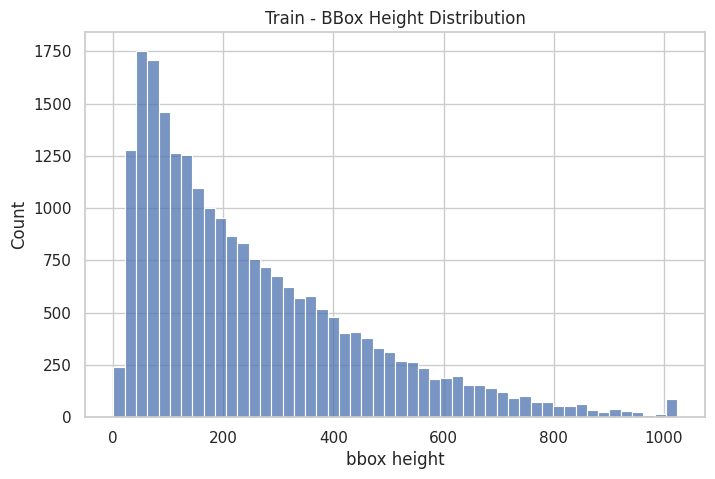

/data/ephemeral/home/py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


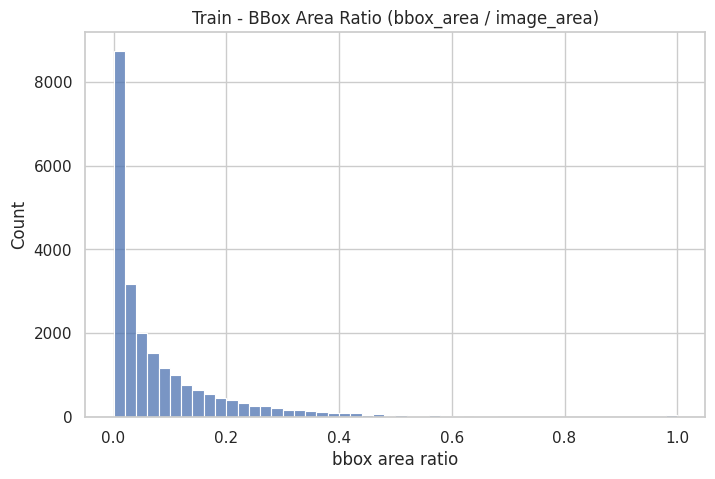

In [8]:
# ============================================================
# 7. BBox 크기 / 비율 분포 (train)
# ============================================================

plt.figure()
sns.histplot(train_df["bbox_area"], bins=50)
plt.title("Train - BBox Area Distribution (pixel^2)")
plt.xlabel("bbox area")
plt.ylabel("Count")
plt.yscale("log")
plt.show()

plt.figure()
sns.histplot(train_df["bbox_w"], bins=50)
plt.title("Train - BBox Width Distribution")
plt.xlabel("bbox width")
plt.ylabel("Count")
plt.show()

plt.figure()
sns.histplot(train_df["bbox_h"], bins=50)
plt.title("Train - BBox Height Distribution")
plt.xlabel("bbox height")
plt.ylabel("Count")
plt.show()

train_df["bbox_w_ratio"] = train_df["bbox_w"] / train_df["width"]
train_df["bbox_h_ratio"] = train_df["bbox_h"] / train_df["height"]
train_df["bbox_area_ratio"] = train_df["bbox_area"] / (train_df["width"] * train_df["height"])

plt.figure()
sns.histplot(train_df["bbox_area_ratio"], bins=50)
plt.title("Train - BBox Area Ratio (bbox_area / image_area)")
plt.xlabel("bbox area ratio")
plt.ylabel("Count")
plt.show()



=== General trash ===
- bbox 개수: 3966
- bbox area 통계:


count    3.966000e+03
mean     7.886015e+04
std      1.394229e+05
min      5.600000e-01
25%      4.938038e+03
50%      1.948153e+04
75%      8.753023e+04
max      1.048064e+06
Name: bbox_area, dtype: float64

/data/ephemeral/home/py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


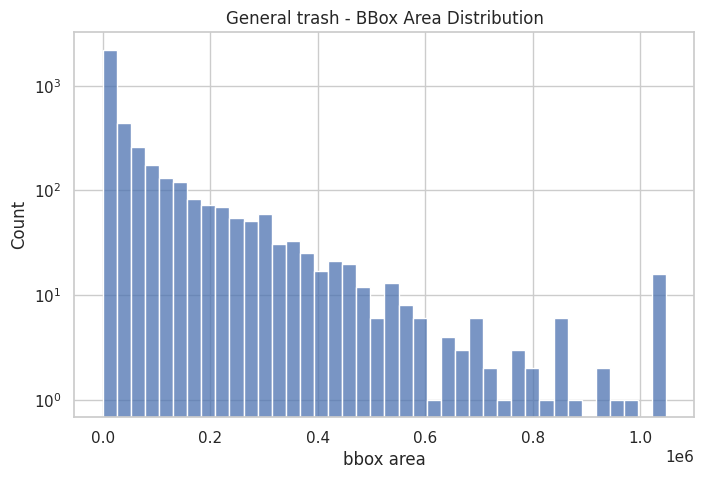


=== Plastic bag ===
- bbox 개수: 5178
- bbox area 통계:


count    5.178000e+03
mean     1.103577e+05
std      1.395596e+05
min      3.017100e+02
25%      1.780576e+04
50%      6.250520e+04
75%      1.468789e+05
max      1.048371e+06
Name: bbox_area, dtype: float64

/data/ephemeral/home/py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


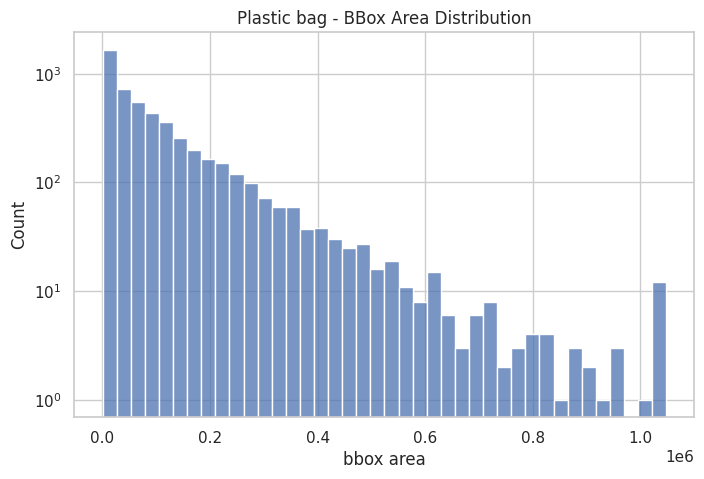


=== Paper ===
- bbox 개수: 6352
- bbox area 통계:


count    6.352000e+03
mean     9.204420e+04
std      1.413165e+05
min      3.120000e+00
25%      9.473845e+03
50%      3.564533e+04
75%      1.149328e+05
max      1.048064e+06
Name: bbox_area, dtype: float64

/data/ephemeral/home/py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


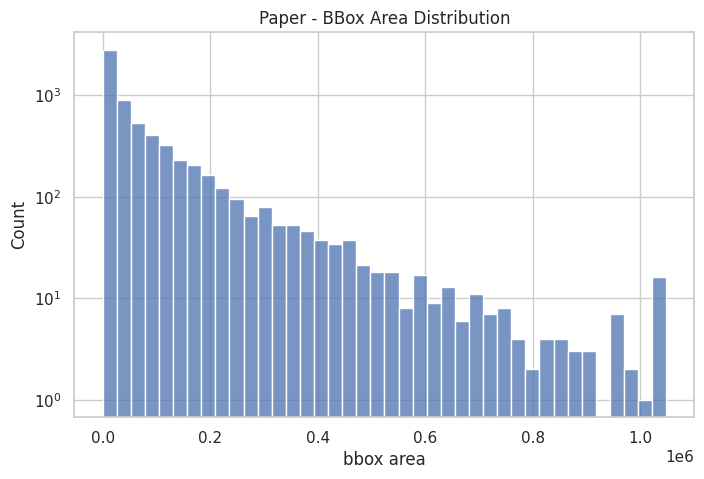


=== Plastic ===
- bbox 개수: 2943
- bbox area 통계:


count    2.943000e+03
mean     8.099061e+04
std      1.248586e+05
min      1.050800e+02
25%      7.651095e+03
50%      2.880100e+04
75%      9.930846e+04
max      1.047962e+06
Name: bbox_area, dtype: float64

/data/ephemeral/home/py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


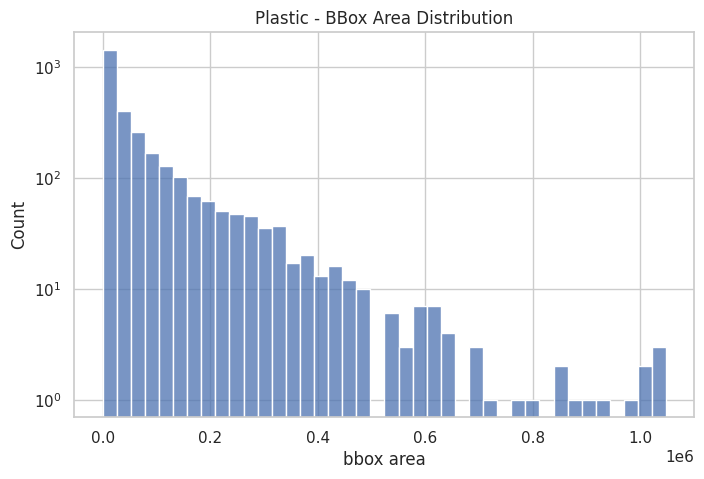

In [9]:
# ============================================================
# 8. 특정 클래스별 BBox 면적 분포 (예: General trash, Plastic bag, Paper, Plastic)
# ============================================================

target_classes = ["General trash", "Plastic bag", "Paper", "Plastic"]

for cls in target_classes:
    cls_df = train_df[train_df["category_name"] == cls]
    if len(cls_df) == 0:
        print(f"\n[경고] '{cls}' 클래스는 train 데이터에 존재하지 않습니다.")
        continue

    print(f"\n=== {cls} ===")
    print(f"- bbox 개수: {len(cls_df)}")
    print("- bbox area 통계:")
    display(cls_df["bbox_area"].describe())

    plt.figure()
    sns.histplot(cls_df["bbox_area"], bins=40)
    plt.title(f"{cls} - BBox Area Distribution")
    plt.xlabel("bbox area")
    plt.ylabel("Count")
    plt.yscale("log")
    plt.show()



=== BBox size (S/M/L) 분포 ===


bbox_size
large     17637
medium     5194
small       313
Name: count, dtype: int64

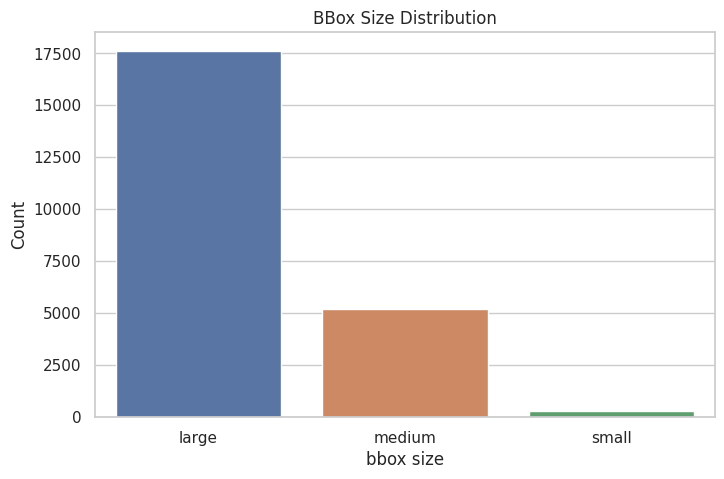

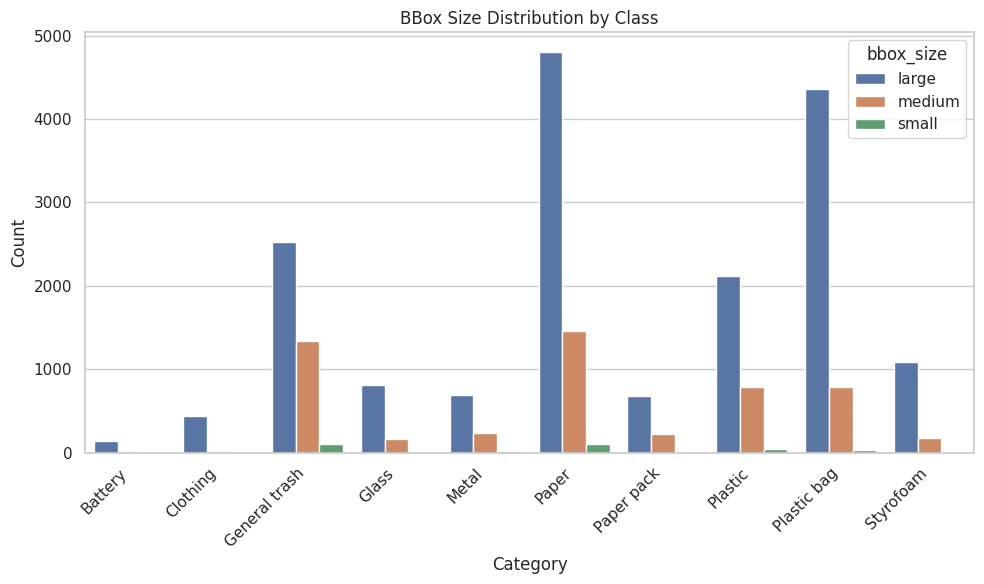

In [10]:
# ============================================================
# 9. BBox Scale 구간(S/M/L) 비율 보기 (COCO 스타일)
#    - Small: area < 32^2
#    - Medium: 32^2 <= area < 96^2
#    - Large: area >= 96^2
# ============================================================

def categorize_bbox_size(area):
    if area < 32**2:
        return "small"
    elif area < 96**2:
        return "medium"
    else:
        return "large"

train_df["bbox_size"] = train_df["bbox_area"].apply(categorize_bbox_size)

size_counts = train_df["bbox_size"].value_counts()
print("\n=== BBox size (S/M/L) 분포 ===")
display(size_counts)

plt.figure()
sns.barplot(x=size_counts.index, y=size_counts.values)
plt.title("BBox Size Distribution")
plt.xlabel("bbox size")
plt.ylabel("Count")
plt.show()

size_by_class = (
    train_df.groupby(["category_name", "bbox_size"])["id"]
    .count()
    .reset_index()
    .rename(columns={"id": "count"})
)

plt.figure(figsize=(10, 6))
sns.barplot(data=size_by_class, x="category_name", y="count", hue="bbox_size")
plt.xticks(rotation=45, ha="right")
plt.title("BBox Size Distribution by Class")
plt.xlabel("Category")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


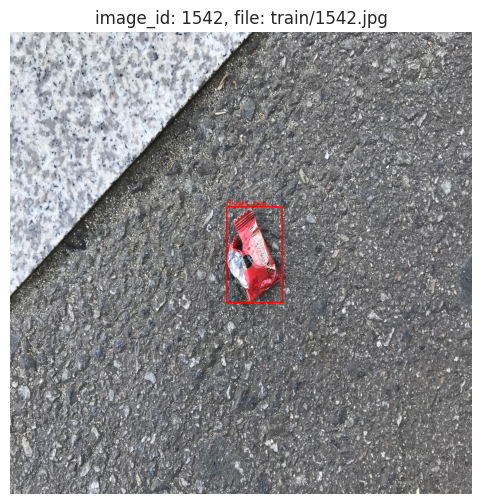

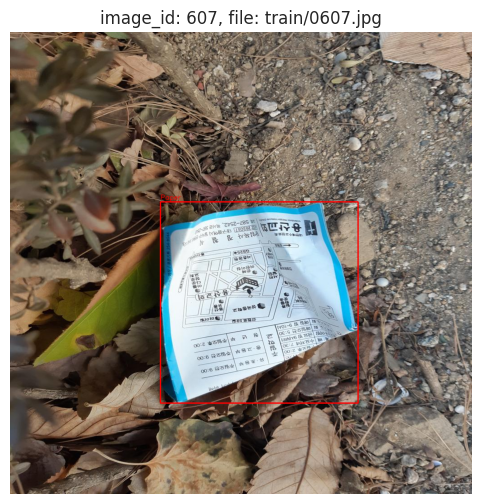

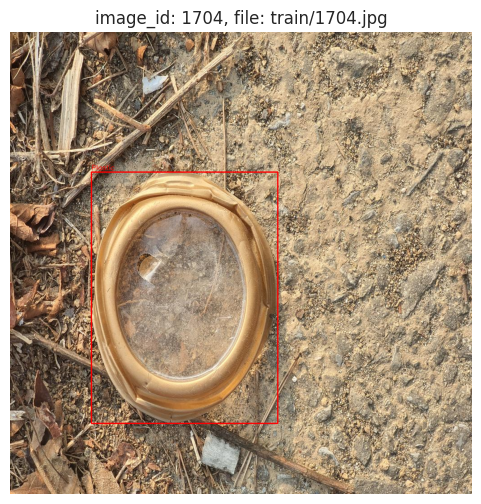

In [12]:
# ============================================================
# 10. 예시 이미지 시각화 (랜덤 샘플)
# ============================================================

def show_random_image_with_bboxes(df, img_root, n_samples=3):
    """임의 이미지 n개를 선택해 bbox와 함께 시각화.
    img_root: file_name 앞에 붙일 루트 경로 (예: /home/dataset)
    """
    unique_ids = df["image_id"].unique().tolist()
    if len(unique_ids) == 0:
        print("시각화할 image_id가 없습니다.")
        return

    sample_image_ids = random.sample(unique_ids, k=min(n_samples, len(unique_ids)))

    for image_id in sample_image_ids:
        img_info = train_images[train_images["id"] == image_id].iloc[0]
        file_name = img_info["file_name"]          # 예: 'train/0753.jpg'
        img_path = os.path.join(img_root, file_name)  # /home/dataset/train/0753.jpg

        if not os.path.exists(img_path):
            print(f"[경고] 이미지 파일이 없습니다: {img_path}")
            continue

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        ann_subset = df[df["image_id"] == image_id]

        for _, row in ann_subset.iterrows():
            x, y, w, h = row["bbox_x"], row["bbox_y"], row["bbox_w"], row["bbox_h"]
            cls_name = row["category_name"]

            x1, y1, x2, y2 = int(x), int(y), int(x + w), int(y + h)
            cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)
            cv2.putText(
                img,
                cls_name,
                (x1, max(0, y1 - 5)),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.5,
                (255, 0, 0),
                1,
                cv2.LINE_AA,
            )

        plt.figure(figsize=(6, 6))
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"image_id: {image_id}, file: {file_name}")
        plt.show()


# 호출할 때는 TRAIN_IMG_DIR 대신 DATA_DIR 을 넣기
show_random_image_with_bboxes(train_df, DATA_DIR, n_samples=3)